In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from model import *
from dataset import *
import util
import json
from collections import defaultdict

# Evaluate the model on the entire dataset
data = HD5Dataset('../data/data_dragon.hd5', seed=42, features=["FirstCharge", "CumulativeCharge", "Time",
            "VertexX", "VertexY", "VertexZ", "RecoX",
"RecoZ", "RecoAzimuth", "RecoZenith"])

In [4]:
with open('training/hd5-690638/config.json') as f:
    settings = json.load(f)

In [5]:
data = util.dataset_from_config(settings)

Loaded feature ChargeFirstPulse
Loaded feature TimeFirstPulse
Loaded feature ChargeLastPulse
Loaded feature TimeLastPulse
Loaded feature TimeVariance
Loaded feature IntegratedCharge
Loaded feature TimeMaxPulse
Loaded feature ChargeMaxPulse
Loaded feature VertexX
Loaded feature VertexY
Loaded feature VertexZ
0 of 27, slice 0:50000000

1 of 27, slice 50000000:100000000

2 of 27, slice 100000000:150000000

3 of 27, slice 150000000:200000000

4 of 27, slice 200000000:250000000

5 of 27, slice 250000000:300000000

6 of 27, slice 300000000:350000000

7 of 27, slice 350000000:400000000

8 of 27, slice 400000000:450000000

9 of 27, slice 450000000:500000000

10 of 27, slice 500000000:550000000

11 of 27, slice 550000000:600000000

12 of 27, slice 600000000:650000000

13 of 27, slice 650000000:700000000

14 of 27, slice 700000000:750000000

15 of 27, slice 750000000:800000000

16 of 27, slice 800000000:850000000

17 of 27, slice 850000000:900000000

18 of 27, slice 900000000:950000000

19 of 27

In [6]:
model = util.model_from_config(settings)

In [11]:
model.load_weights('training/hd5-690638/model_weights.h5')

In [12]:
model.weights

[<tf.Variable 'gaussian_adjacency_matrix/sigma:0' shape=(1,) dtype=float32, numpy=array([0.82602614], dtype=float32)>,
 <tf.Variable 'graph_convolution/dense/kernel:0' shape=(11, 64) dtype=float32, numpy=
 array([[-2.68908292e-01,  1.32053629e-01, -2.31160522e-01,
          2.69661605e-01,  1.81369156e-01, -4.66915935e-01,
          1.28480121e-01,  1.29230976e-01, -1.40301570e-01,
          2.65806794e-01, -3.11934918e-01, -1.65368356e-02,
         -1.65329039e-01, -2.48479635e-01,  6.28587082e-02,
          2.47932933e-02, -1.36718765e-01, -2.25914657e-01,
          2.26100177e-01,  1.76443011e-01,  3.73358399e-01,
          3.55510563e-01,  4.42932010e-01, -6.46030232e-02,
         -2.72790015e-01, -4.72071506e-02, -8.49246159e-02,
         -2.43955910e-01,  7.40200747e-03, -3.74477267e-01,
         -6.42377213e-02,  8.67608562e-02, -2.73888737e-01,
          5.56377880e-02, -2.52086818e-01,  5.33646047e-02,
         -2.48824835e-01, -2.12260008e-01, -1.99109107e-01,
         -4.978

In [8]:
data.get_baseline_accuracy()

0.6168745687620293

In [9]:
test_idx = data._get_idx('test')

In [13]:
# Evaluate the model on all the data
batch_size = 128
logits_model = model.predict_generator(data.get_batches(batch_size=batch_size, dataset='test'),
                       steps=int(np.ceil(data.size(dataset='test') / batch_size)))

In [14]:
logits_model

array([[0.5398277 ],
       [0.57730997],
       [0.5404612 ],
       ...,
       [0.57936126],
       [0.53503376],
       [0.55218536]], dtype=float32)

In [15]:
np.unique(logits_model).shape

(190205,)

In [16]:
y_model = (logits_model >= 0.5).astype(np.int)

In [17]:
np.unique(y_model)

array([0, 1])

In [18]:
y_model = y_model.squeeze()

In [19]:
# Get the pe counts (~charge) of the test data
total_charge = data.file['TotalCharge']['value'][test_idx]

In [20]:
y_gnd = data.targets[test_idx]
y_baseline = (data.delta_loglikelihood[test_idx] >= 2.0).astype(np.uint8)

In [21]:
total_charge
total_charge.max(), total_charge.min()

(1273.7999909073114, 7.0)

In [22]:
bins = np.logspace(0.8, 3.2)
binned = np.digitize(total_charge, bins)
#np.unique(binned)

In [23]:
def get_metrics(y_pred, y_gnd):
    acc = (y_pred == y_gnd).sum() / len(y_pred)
    tpr = (y_pred[y_gnd == 1] == 1).sum() / ((y_gnd == 1).sum() + 1e-20)
    tnr = (y_pred[y_gnd == 0] == 0).sum() / ((y_gnd == 0).sum() + 1e-20)
    ppr = (y_pred == 1).sum() / y_pred.shape[0]
    return acc, tpr, tnr, ppr

In [24]:
pgd_encoding = np.array(data.file['PDGEncoding']['value'], dtype=np.uint8).astype(np.int8)
pgd_encoding.shape

(2202957,)

In [25]:
(np.abs(pgd_encoding) == 12).sum()

524922

In [26]:
interaction_types = np.array(data.file['InteractionType']['value'], dtype=np.uint8)
interaction_types

array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)

In [27]:
np.unique(pgd_encoding, return_counts=True)

(array([-16, -14, -12,  12,  14,  16], dtype=int8),
 array([  46767,  467199,  164192,  360730, 1036437,  127632]))

In [28]:
np.logical_and((interaction_types == 1), (np.abs(pgd_encoding) == 14)).sum() / interaction_types.shape[0]

0.618337988440083

In [29]:
np.unique(interaction_types)

array([1, 2], dtype=uint8)

In [30]:
data.file.keys()

<KeysViewHDF5 ['CascadeEnergy', 'ChargeFirstPulse', 'ChargeLastPulse', 'ChargeMaxPulse', 'DeltaLLH', 'Distances', 'DistancesOffset', 'IC86_Dunkman_L6_SANTA_DirectCharge', 'IntegratedCharge', 'InteractionType', 'MuonEnergy', 'NumberChannels', 'NumberVertices', 'Offset', 'PDGEncoding', 'RecoAzimuth', 'RecoX', 'RecoY', 'RecoZ', 'RecoZenith', 'TimeFirstPulse', 'TimeLastPulse', 'TimeMaxPulse', 'TimeVariance', 'TotalCharge', 'TrackLength', 'VertexDeltaLLH', 'VertexX', 'VertexY', 'VertexZ']>

In [31]:
y_gnd2 = np.logical_and((interaction_types == 1), (np.abs(pgd_encoding) == 14)).astype(np.int)

In [32]:
metrics = defaultdict(lambda: defaultdict(list))
for bin_idx, value in enumerate(bins):
    for interaction_type, pgd_code in (('nue', 12), ('numu CC', 14), ('numu NC', 14), ('nutau', 16)):
        # print((np.abs(pgd_encoding) == pgd_code).sum(), pgd_code)
        bin_mask = binned == bin_idx
        enc_mask = np.abs(pgd_encoding[test_idx] == pgd_code)
        if 'numu' in interaction_type:
            it = 1 if 'CC' in interaction_type else 2
            it_mask = interaction_types[test_idx] == it
            #print(it, it_mask.sum())
            idxs = np.where(np.logical_and(bin_mask, np.logical_and(enc_mask, it_mask)))[0]
        else:
            idxs = np.where(np.logical_and(bin_mask, enc_mask))[0]
        # print(idxs.shape)
        for y, t in ((y_model, 'model'), (y_baseline, 'baseline')):
            acc, tpr, tnr, ppr = get_metrics(y[idxs], y_gnd[idxs])
            metrics[interaction_type][t].append({
                'acc' : acc, 'tpr' : tpr, 'ppr' : ppr, 'bin_idx' : bin_idx, 'value' : value, 'num_samples' : idxs.shape[0]
            })

/home/dominik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
/home/dominik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """


In [33]:
dfs = {
    pgd_code : {
            type_ : pd.DataFrame(data) for type_, data in metrics_code.items()
        } for pgd_code, metrics_code in metrics.items()
    }
for pgd_code, metrics_code in dfs.items():
    for type_, df in metrics_code.items():
        df = df[df['num_samples'] > 100]
        metrics_code[type_] = df

In [34]:
dfs['numu NC']

{'model':          acc  bin_idx  num_samples       ppr  tpr       value
 3   0.184211        3          152  0.815789  0.0    8.849908
 4   0.254777        4          314  0.745223  0.0    9.906457
 5   0.226506        5          415  0.773494  0.0   11.089142
 6   0.200000        6          565  0.800000  0.0   12.413023
 7   0.156300        7          627  0.843700  0.0   13.894955
 8   0.135246        8          732  0.864754  0.0   15.553808
 9   0.082192        9          657  0.917808  0.0   17.410704
 10  0.076135       10          683  0.923865  0.0   19.489286
 11  0.070229       11          655  0.929771  0.0   21.816019
 12  0.064516       12          589  0.935484  0.0   24.420531
 13  0.046472       13          581  0.953528  0.0   27.335983
 14  0.048598       14          535  0.951402  0.0   30.599497
 15  0.037037       15          486  0.962963  0.0   34.252626
 16  0.035129       16          427  0.964871  0.0   38.341886
 17  0.025189       17          397  0.974811 

In [35]:
def plot_metric(metric, metric_name):
    colors = ['blue', 'green', 'red', 'purple']
    fig = plt.figure()
    plt.xscale('log')
    for (pgd_code, df), color in zip(dfs.items(), colors):
        for t in df.keys():
            if t == 'model':
                plt.plot(df[t]['value'], df[t][metric], label=f'{pgd_code} (model)', color=color)
            else:
                plt.plot(df[t]['value'], df[t][metric], label=f'{pgd_code} (baseline)', linestyle='dashed', color=color)
    plt.legend(loc='left', bbox_to_anchor=(1.0, 1.05))
    plt.title(metric_name)
    plt.xlabel('log(Integrated Charge) (pe)')


/usr/local/lib/python3.6/dist-packages/matplotlib-3.0.3-py3.6-linux-x86_64.egg/matplotlib/legend.py:497: UserWarning: Unrecognized location "left". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


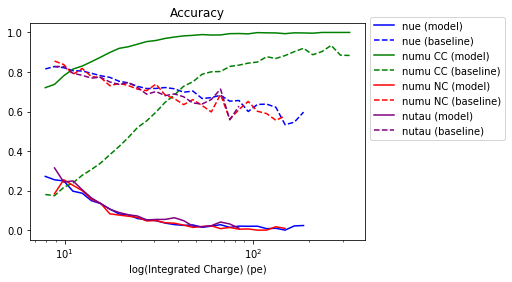

In [36]:
plot_metric('acc', 'Accuracy', )

In [37]:
y_model

array([1, 1, 1, ..., 1, 1, 1])

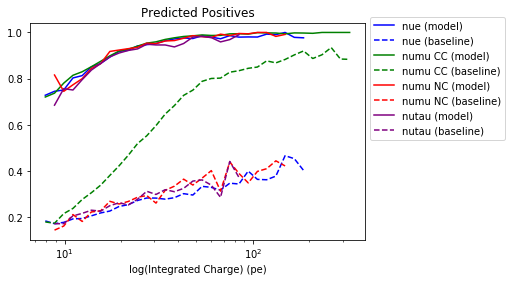

In [38]:
plot_metric('ppr', 'Predicted Positives')

In [53]:
bins_track, bin_counts_track = np.unique(binned[y_gnd > 0], return_counts=True)
bins_non_track, bin_counts_non_track = np.unique(binned[y_gnd <= 0], return_counts=True)
bin_counts_non_track, bin_counts_track


(array([  27,  418, 1538, 3238, 4838, 5998, 6370, 6698, 6343, 6066, 5577,
        5028, 4475, 3882, 3457, 3020, 2688, 2287, 1883, 1639, 1381, 1195,
        1034,  843,  742,  634,  526,  441,  354,  327,  230,  172,  137,
         121,   75,   34,   39,   31,   22,   11,   11,    6,    4,    6,
           1]),
 array([  22,  563, 1881, 4187, 6195, 7593, 8467, 9052, 9223, 9002, 8683,
        8226, 7689, 7063, 6509, 5956, 5386, 4733, 4177, 3774, 3175, 2802,
        2464, 2007, 1654, 1419, 1120,  872,  682,  510,  363,  264,  198,
         147,  125,   95,   44,   44,   31,   13,    9,    8,    9,    4,
           3,    4,    1]))

Text(0.5, 0, 'log(Integrated Charge) (pe)')

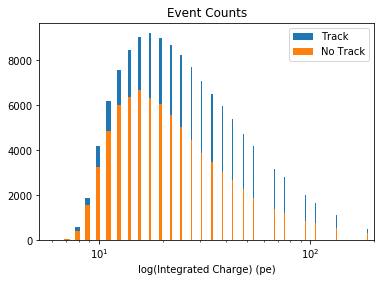

In [57]:
fig = plt.figure()
plt.xscale('log')
plt.bar(bins[bins_track], bin_counts_track, width=0.5, label='Track')
plt.bar(bins[bins_non_track], bin_counts_non_track, width=0.5, label='No Track')
plt.legend()
plt.xlim(right=2e2)
plt.title('Event Counts')
plt.xlabel('log(Integrated Charge) (pe)')

In [39]:
np.hstack((
    np.array(pd.DataFrame(metrics['numu CC']['model'])['acc']),
    np.array(pd.DataFrame(metrics['numu CC']['model'])['acc'])
    )
)

array([       nan, 0.625     , 0.72062663, 0.73729476, 0.78070175,
       0.81468954, 0.82993459, 0.85187737, 0.87502039, 0.89870417,
       0.91946309, 0.92762712, 0.94058866, 0.95376282, 0.95935648,
       0.96981216, 0.97681954, 0.98256131, 0.98535369, 0.98923237,
       0.98695318, 0.98734177, 0.99385561, 0.99450549, 0.99284692,
       0.99914457, 0.998     , 0.99751553, 0.99384615, 0.99797571,
       0.99741602, 0.9962406 , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        ,        nan, 1.        ,        nan,
              nan, 0.625     , 0.72062663, 0.73729476, 0.78070175,
       0.81468954, 0.82993459, 0.85187737, 0.87502039, 0.89870417,
       0.91946309, 0.92762712, 0.94058866, 0.95376282, 0.95935648,
       0.96981216, 0.97681954, 0.98256131, 0.98535369, 0.98923237,
       0.98695318, 0.98734177, 0.99385561, 0.99450549, 0.99284

In [89]:
total_charge_sorted = np.sort(total_charge)

In [19]:
# Find different cutoff values to check performance at different maximal energies by selecting the quantiles of the data
cutoffs = []
quantiles = []
for quantile in np.arange(0.00, 1.0, 0.01):
    quantile = 1.0 - quantile
    quantiles.append(quantile)
    cutoffs.append(total_charge_sorted[int(total_charge.shape[0] * quantile) - 1])

In [20]:
y_model.shape, y_gnd.shape

((220295,), (220295,))

In [22]:
metrics = defaultdict(lambda: defaultdict(list))
for cutoff, quantile in zip(cutoffs, quantiles):
    mask = total_charge <= cutoff
    acc_baseline, tpr_baseline, tnr_baseline, ppr_baseline = get_metrics(y_baseline[mask], y_gnd[mask])
    metrics['baseline']['accuracy'].append(acc_baseline)
    metrics['baseline']['tpr'].append(tpr_baseline)
    metrics['baseline']['tnr'].append(tnr_baseline)
    metrics['baseline']['ppr'].append(ppr_baseline)
    acc_model, tpr_model, tnr_model, ppr_model = get_metrics(y_model[mask], y_gnd[mask])
    metrics['model']['accuracy'].append(acc_model)
    metrics['model']['tpr'].append(tpr_model)
    metrics['model']['tnr'].append(tnr_model)
    metrics['model']['ppr'].append(ppr_model)
    metrics['gnd']['ppr'].append((y_gnd[mask] == 1).sum() / y_gnd[mask].shape[0])

Text(0.5, 0.04, 'Integrated Charge (pe)')

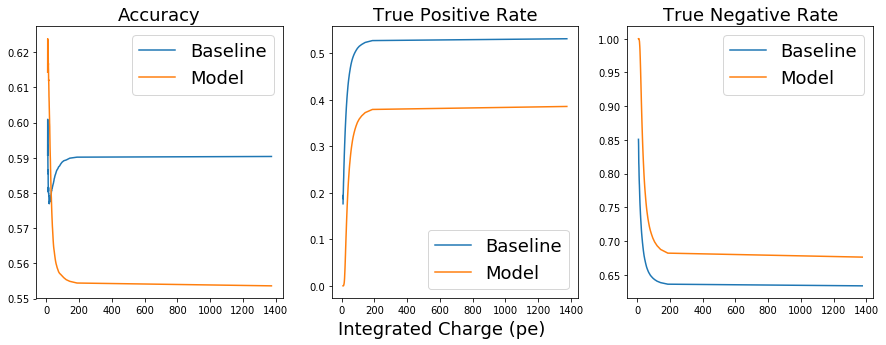

In [23]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(131)
ax1.plot(cutoffs, metrics['baseline']['accuracy'], label='Baseline')
ax1.plot(cutoffs, metrics['model']['accuracy'], label='Model')
ax1.set_title('Accuracy', fontsize=18)
ax1.legend(fontsize=18)
ax2 = fig.add_subplot(132)
ax2.plot(cutoffs, metrics['baseline']['tpr'], label='Baseline')
ax2.plot(cutoffs, metrics['model']['tpr'], label='Model')
ax2.set_title('True Positive Rate', fontsize=18)
ax2.legend(fontsize=18)
ax3 = fig.add_subplot(133)
ax3.plot(cutoffs, metrics['baseline']['tnr'], label='Baseline')
ax3.plot(cutoffs, metrics['model']['tnr'], label='Model')
ax3.set_title('True Negative Rate', fontsize=18)
ax3.legend(fontsize=18)
fig.text(0.5, 0.04, 'Integrated Charge (pe)', ha='center', va='center', fontsize=18)



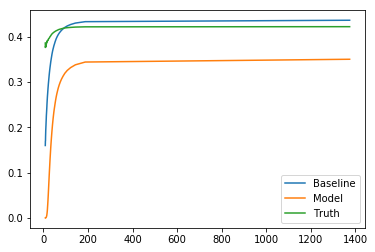

In [24]:
fig = plt.figure()
plt.plot(cutoffs, metrics['baseline']['ppr'], label='Baseline')
plt.plot(cutoffs, metrics['model']['ppr'], label='Model')
plt.plot(cutoffs, metrics['gnd']['ppr'], label='Truth')
plt.legend()


In [31]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
adjacency_matrix_layer_1 (Ad multiple                  1         
_________________________________________________________________
gcnn_block_4 (GCNNBlock)     multiple                  1088      
_________________________________________________________________
gcnn_block_5 (GCNNBlock)     multiple                  16448     
_________________________________________________________________
gcnn_block_6 (GCNNBlock)     multiple                  16448     
_________________________________________________________________
gcnn_block_7 (GCNNBlock)     multiple                  16448     
_________________________________________________________________
dense_2 (Dense)              multiple                  2080      
_________________________________________________________________
batch_normalization_v1_1 (Ba multiple                  128       
__________

In [32]:
model.weights

[<tf.Variable 'adjacency_matrix_layer_1/sigma:0' shape=(1,) dtype=float32, numpy=array([-1.1994079], dtype=float32)>,
 <tf.Variable 'gcnn_block_4/dense/kernel:0' shape=(16, 64) dtype=float32, numpy=
 array([[-6.7605382e-01, -5.5014306e-01,  1.0545670e+00, ...,
          5.9158012e-02,  4.1892594e-01,  1.1311057e+00],
        [-1.1726910e-01, -3.6698148e-02, -2.5776282e-02, ...,
         -1.6091052e-01, -3.3308864e-03,  1.9296408e-02],
        [-4.5562524e-01, -7.2932534e-02,  3.4593046e-01, ...,
         -2.7987896e-02,  1.9500892e-01,  7.2564250e-01],
        ...,
        [ 2.4853425e-02,  5.2007634e-02,  1.5153764e-04, ...,
         -1.7101361e-01,  9.0077855e-03, -3.0158782e-01],
        [ 1.8562905e-01, -2.1861477e-01, -2.6344028e-01, ...,
         -1.6159213e-01,  5.9850786e-02, -1.6955628e-01],
        [ 1.4021096e-01, -1.9073695e-01, -1.7653483e-01, ...,
          9.7623197e-03, -1.5720429e-02, -1.2895808e-01]], dtype=float32)>,
 <tf.Variable 'gcnn_block_4/dense/bias:0' shape=(6

In [131]:
np.unique(y_model)

array([0])

# Investigate attributes of the dataset

In [5]:
file = h5py.File('../data/data_dragon2.hd5')

In [13]:
idx = np.arange(file['TimeStdDeviation'].shape[0])
np.random.shuffle(idx)

In [14]:
samples = idx[:100000]

In [18]:
file.keys()

<KeysViewHDF5 ['ChargeFirstPulse', 'ChargeLastPulse', 'DeltaLLH', 'IC86_Dunkman_L6_SANTA_DirectCharge', 'IntegratedCharge', 'InteractionType', 'NumberChannels', 'NumberVertices', 'Offset', 'PDGEncoding', 'RecoAzimuth', 'RecoX', 'RecoY', 'RecoZ', 'RecoZenith', 'TimeFirstPulse', 'TimeLastPulse', 'TimeStdDeviation', 'TotalCharge', 'VertexX', 'VertexY', 'VertexZ', '__I3Index__']>

In [42]:
time_std_samples = file['TimeStdDeviation']['item'][samples]

In [38]:
time_std_samples = time_std_samples[time_std_samples < 1e-5]

In [43]:
time_std_samples

array([1.2055448e-03, 1.1102230e-16, 0.0000000e+00, ..., 0.0000000e+00,
       0.0000000e+00, 2.8057413e-03], dtype=float32)

(array([76768.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,  4604.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,   264.]),
 array([0.00000000e+00, 2.22044600e-18, 4.44089200e-18, 6.66133800e-18,
        8.88178400e-18

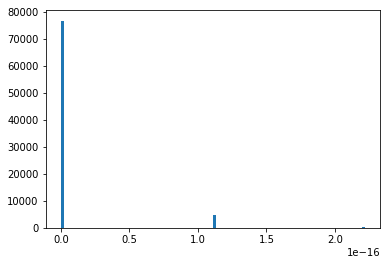

In [39]:
plt.hist(time_std_samples, bins=100)

In [40]:
charge_samples = file['ChargeFirstPulse']['item'][samples]

In [27]:
charge_samples = charge_samples[charge_samples <= 5]

(array([3072., 3387., 3761., 4108., 4557., 5143., 5673., 5869., 6233.,
           0., 6162., 6139., 5778., 5318., 4768., 4331., 3793., 3172.,
           0., 2688., 2301., 1654., 1348., 1078.,  891.,  731.,  589.,
           0.,  528.,  435.,  373.,  360.,  345.,  307.,  296.,  278.,
           0.,  259.,  222.,  214.,  202.,  214.,  174.,  185.,  134.,
           0.,  137.,  121.,  134.,   90.,  136.,   94.,   87.,   85.,
           0.,   75.,   86.,   84.,   47.,   75.,   48.,   55.,   42.,
           0.,   39.,   36.,   49.,   49.,   39.,   48.,   36.,   37.,
           0.,   32.,   27.,   32.,   32.,   41.,   35.,   43.,   27.,
           0.,   28.,   21.,   21.,   24.,   27.,   20.,   18.,   13.,
           0.,   24.,   15.,   21.,   18.,   13.,   21.,   15.,   14.,
          11.]),
 array([0.525     , 0.56949997, 0.61399996, 0.65849996, 0.70299995,
        0.74749994, 0.792     , 0.8365    , 0.881     , 0.9255    ,
        0.96999997, 1.0145    , 1.059     , 1.1035    , 1.148     

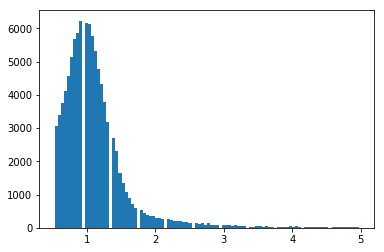

In [29]:
plt.hist(charge_samples, bins=100)

In [48]:
time_samples = file['TimeFirstPulse']['item'][samples]

In [51]:
time_samples_filtered = time_samples[time_samples > -0.002]

In [55]:
time_samples_filtered.std()

0.00030537526